In [1]:
!git clone https://github.com/niravjain98/SemanticSegmantation.git

Cloning into 'SemanticSegmantation'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 28 (delta 7), reused 17 (delta 2), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [2]:
!pip install -r SemanticSegmantation/requirements.txt

     |████████████████████████████████| 50.0MB 63kB/s 
     |████████████████████████████████| 411.0MB 40kB/s 
     |████████████████████████████████| 512kB 55.3MB/s 
     |████████████████████████████████| 3.8MB 53.3MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=4cbf27af97380400689f7fc931bfc22136c4d25f5210e086cb81ea872e7d1077
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.0.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.0.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tenso

In [ ]:

#Download dataset to root directory
!wget -N https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip

#Create data_dir:
!mkdir -p SemanticSegmantation/dataset

#Copy data_road.zip from root directory to the data_dir created above
!mv data_road.zip SemanticSegmantation/dataset/

#Unzip the data_road.zip in its own directory
!cd SemanticSegmantation/dataset/ && unzip data_road.zip && rm data_road.zip




In [4]:
#!ls
#%cd SemanticSegmantation/
#!ls




--2020-10-04 17:22:33--  http://www.pngall.com/wp-content/uploads/1/Road.png
Resolving www.pngall.com (www.pngall.com)... 82.192.95.147
Connecting to www.pngall.com (www.pngall.com)|82.192.95.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/png]
Saving to: ‘Road.png’

Road.png                [       <=>          ] 917.49K   583KB/s    in 1.6s    

2020-10-04 17:22:35 (583 KB/s) - ‘Road.png’ saved [939509]

rm: cannot remove '/content/Road.png': No such file or directory


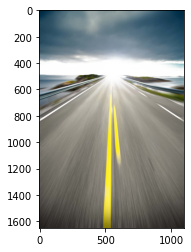

(1650, 1100, 4)


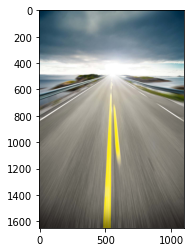

(1650, 1100, 3)


In [5]:
#Read an image using PIL
from PIL import Image
#filename = "nigga.png"
!wget http://www.pngall.com/wp-content/uploads/1/Road.png
!mv Road.png SemanticSegmantation/dataset/data_road/testing/image_2/
!rm /content/Road.png
img = Image.open("/content/SemanticSegmantation/dataset/data_road/testing/image_2/Road.png")
#Convert img to numpy array
import numpy as np
image_array=np.asarray(img)
#Show the image using Matplotlib
import matplotlib.pyplot as plt
plt.imshow(image_array)
plt.show()
#Check shape of image and convert it to 3 channels if required
print(image_array.shape)
image_array_rgb=image_array[:,:,0:3]
plt.imshow(image_array_rgb)
plt.show()
print(image_array_rgb.shape)
img=Image.fromarray(image_array_rgb)
img.save("Road.png")
!cd SemanticSegmantation/dataset/data_road/testing/image_2/ && rm Road.png
!mv Road.png SemanticSegmantation/dataset/data_road/testing/image_2/

#print(img.shape)


In [1]:
%cd SemanticSegmantation
# % executes the command for the ongoing jupiter session while ! is used for the background
import tensorflow as tf
import helper


#Tune these parameters

NUMBER_OF_CLASSES = 2
IMAGE_SHAPE = (160,576)
EPOCHS = 5
BATCH_SIZE = 20
DROPOUT = 0.75

#Specify the directory paths

data_dir = './dataset'
runs_dir = './runs'
training_dir = './dataset/data_road/training'
vgg_path = './dataset/vgg'

#PLACEHOLDERS TENSORS

correct_label = tf.placeholder(tf.float32, [None, IMAGE_SHAPE[0], IMAGE_SHAPE[1], NUMBER_OF_CLASSES]) #SHAPE = [None,160,576,2]
learning_rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)

#FUNCTIONS

def load_vgg(sess, vgg_path):

  # load the model and weights
  model = tf.saved_model.loader.load(sess, ['vgg16'], vgg_path)

  # Get Tensors to be returned from graph
  graph = tf.get_default_graph()
  image_input = graph.get_tensor_by_name('image_input:0')
  keep_prob = graph.get_tensor_by_name('keep_prob:0')
  layer3 = graph.get_tensor_by_name('layer3_out:0')
  layer4 = graph.get_tensor_by_name('layer4_out:0')
  layer7 = graph.get_tensor_by_name('layer7_out:0')

  return image_input, keep_prob, layer3, layer4, layer7

def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, NUMBER_OF_CLASSES):
   
    # Use a shorter variable name for simplicity
    layer3, layer4, layer7 = vgg_layer3_out, vgg_layer4_out, vgg_layer7_out

    # Apply 1x1 convolution in place of fully connected layer
    fcn8 = tf.layers.conv2d(layer7, filters=NUMBER_OF_CLASSES, kernel_size=1, name="fcn8")

    # Upsample fcn8 with size depth=(4096?) to match size of layer 4 so that we can add skip connection with 4th layer
    fcn9 = tf.layers.conv2d_transpose(fcn8, filters=layer4.get_shape().as_list()[-1],
    kernel_size=4, strides=(2, 2), padding='SAME', name="fcn9")

    # Add a skip connection between current final layer fcn8 and 4th layer
    fcn9_skip_connected = tf.add(fcn9, layer4, name="fcn9_plus_vgg_layer4")

    # Upsample again
    fcn10 = tf.layers.conv2d_transpose(fcn9_skip_connected, filters=layer3.get_shape().as_list()[-1],
    kernel_size=4, strides=(2, 2), padding='SAME', name="fcn10_conv2d")

    # Add skip connection
    fcn10_skip_connected = tf.add(fcn10, layer3, name="fcn10_plus_vgg_layer3")

    # Upsample again
    fcn11 = tf.layers.conv2d_transpose(fcn10_skip_connected, filters=NUMBER_OF_CLASSES,
    kernel_size=16, strides=(8, 8), padding='SAME', name="fcn11")

    return fcn11

def optimize(nn_last_layer, correct_label, learning_rate, NUMBER_OF_CLASSES):
  
  # Reshape 4D tensors to 2D, each row represents a pixel, each column a class
  logits = tf.reshape(nn_last_layer, (-1, NUMBER_OF_CLASSES), name="fcn_logits")
  correct_label_reshaped = tf.reshape(correct_label, (-1, NUMBER_OF_CLASSES))

  # Calculate distance from actual labels using cross entropy
  cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=correct_label_reshaped[:])
  # Take mean for total loss
  loss_op = tf.reduce_mean(cross_entropy, name="fcn_loss")

  # The model implements this operation to find the weights/parameters that would yield correct pixel labels
  train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_op, name="fcn_train_op")

  return logits, train_op, loss_op

def train_nn(sess, epochs, batch_size, get_batches_fn, train_op,
             cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):

  keep_prob_value = 0.5
  learning_rate_value = 0.001
  for epoch in range(epochs):
      # Create function to get batches
      total_loss = 0
      for X_batch, gt_batch in get_batches_fn(batch_size):

          loss, _ = sess.run([cross_entropy_loss, train_op],
          feed_dict={input_image: X_batch, correct_label: gt_batch,
          keep_prob: keep_prob_value, learning_rate:learning_rate_value})

          total_loss += loss;

      print("EPOCH {} ...".format(epoch + 1))
      print("Loss = {:.3f}".format(total_loss))
      print()

def run():
  
  # Download pretrained vgg model
  helper.maybe_download_pretrained_vgg(data_dir)

  # A function to get batches
  get_batches_fn = helper.gen_batch_function(training_dir, IMAGE_SHAPE)
  
  with tf.Session() as session:
        
    # Returns the three layers, keep probability and input layer from the vgg architecture
    image_input, keep_prob, layer3, layer4, layer7 = load_vgg(session, vgg_path)

    # The resulting network architecture from adding a decoder on top of the given vgg model
    model_output = layers(layer3, layer4, layer7, NUMBER_OF_CLASSES)

    # Returns the output logits, training operation and cost operation to be used
    # - logits: each row represents a pixel, each column a class
    # - train_op: function used to get the right parameters to the model to correctly label the pixels
    # - cross_entropy_loss: function outputting the cost which we are minimizing, lower cost should yield higher accuracy
    logits, train_op, cross_entropy_loss = optimize(model_output, correct_label, learning_rate, NUMBER_OF_CLASSES)
    
    # Initialize all variables
    session.run(tf.global_variables_initializer())
    session.run(tf.local_variables_initializer())

    print("Model about to train, Nigga")

    # Train the neural network
    train_nn(session, EPOCHS, BATCH_SIZE, get_batches_fn, 
             train_op, cross_entropy_loss, image_input,
             correct_label, keep_prob, learning_rate)

    # Run the model with the test images and save each painted output image (roads painted green)
    helper.save_inference_samples(runs_dir, data_dir, session, IMAGE_SHAPE, logits, keep_prob, image_input)
    
    print("All done!")

#--------------------------
# MAIN
#--------------------------
if __name__ == '__main__':
    run()

#FUNCTIONS

def load_vgg(sess, vgg_path):

    model = tf.saved_model.loader.load(sess, ['vgg16'], vgg_path)

    graph = tf.get_default_graph()
    image_input = graph.get_tensor_

/content/SemanticSegmantation
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from ./dataset/vgg/variables/variables
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Model about to train, Nigga
EPOCH 1 ...
Loss = 394.788

EPOCH 2 ...
Loss = 5.444

EPOCH 3 ...
Loss = 3.944

EPOCH 4 ...
Loss = 3.317

EPOCH 5 ...
Loss = 2.766

Training Finished. Saving test images to: ./runs/1601832533.6641555
All done!
